 Following the process and code reference from [U-net Lung Segmentation Kaggle](https://www.kaggle.com/eduardomineo/u-net-lung-segmentation-montgomery-shenzhen), References: https://github.com/zhixuhao/unet/, https://github.com/jocicmarko/ultrasound-nerve-segmentation
 
### [1. Data Preparation ](#data_preparation)
(The training is done with two chest x-rays datasets: [Shenzen & Montogomery CXR dataset](https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#tuberculosis-image-data-sets). The Montgomery County dataset includes manually segmented lung masks, whereas Shenzhen Hospital dataset was manually segmented by Stirenko et al. The lung segmentation masks were dilated to load lung boundary information within the training net and the images were resized to 512x512 pixels)

### [2. Dataset Generator](#dataset_generator)

### [3. Training](#training)

### [4. Validation](#validation)

### [5. Show results](#results)

## 1. Data Preparation
<div id = "data_preparation"> </div>


In [1]:
import sys
sys.path.append('E:\CXR_lungsegmentaion\lung_segmentation')

In [2]:
import os
import glob

import numpy as np
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

#### Define the image path

In [4]:
TRAIN_DIR_MASK = "./data/train/mask"
TRAIN_DIR_IMAGE = "./data/train/image"
TEST_DIR_MASK = "./data/validation/mask"
TEST_DIR_IMAGE = "./data/validation/image"
TRAIN_DIR = "./data/train"
TEST_DIR = "./data/validation"

In [5]:
train_images = [os.path.basename(x) for x in glob.glob(os.path.join(TRAIN_DIR_IMAGE,'*.png'))]
test_images = [os.path.basename(x) for x in glob.glob(os.path.join(TEST_DIR_IMAGE,'*.png'))]  
print(len(train_images), len(test_images))

634 70


#### Visualize the image with its mask

In [6]:
# from https://www.kaggle.com/eduardomineo/u-net-lung-segmentation-montgomery-shenzhen
def add_colored_mask(image, mask_image):
    mask_image_gray = cv.cvtColor(mask_image, cv.COLOR_BGR2GRAY)
    mask = cv.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    mask_coord = np.where(mask!=[0,0,0])
    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    ret = cv.addWeighted(image, 0.7, mask, 0.3, 0)
    return ret

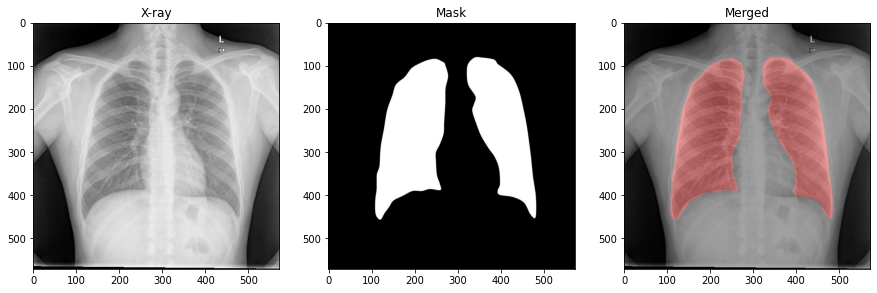

In [7]:
im = cv.imread(os.path.join(TEST_DIR_MASK, test_images[1]))
im1 = cv.imread(os.path.join(TEST_DIR_IMAGE, test_images[1]))
merged_im = add_colored_mask(im1, im)
fig, axs = plt.subplots(1,3, figsize=(15,8))
axs[0].set_title('X-ray')
axs[0].imshow(im1)

axs[1].set_title('Mask')
axs[1].imshow(im)

axs[2].set_title('Merged')
axs[2].imshow(merged_im)

## 2. Dataset Generator
<div id="dataset_generator"></div>

In [8]:
from importlib import import_module

In [ ]:
import os

SAVE_RESULT = './results'

# Check whether the specified path exists or not
isExist_result = os.path.exists(SAVE_RESULT)

if not isExist_result:
  
  # Create a new directory because it does not exist 
  os.makedirs(SAVE_RESULT)
  print("The aug_train directory is created!")


#### Generate image dataset using tensorflow dataset generator.
The dataset should be augmented by using opencv, pillow and scikit image for adjusting brightness, darkness (log value), contrast and dilate masks

In [9]:
from uitilities.data_generator import train_generator, test_load_image, test_generator
# https://www.kaggle.com/eduardomineo/u-net-lung-segmentation-montgomery-shenzhen

BATCH_SIZE_TRAIN = 10
BATCH_SIZE_VAL = 3
EPOCHS = 36

train_generator_args = dict(rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='constant')

train_gen = train_generator(BATCH_SIZE_TRAIN,
                            TRAIN_DIR,
                            'image',
                            'mask', 
                            train_generator_args,
                            target_size=(256,256),
                            save_to_dir=None)

val_image_data = [x for x in glob.glob(os.path.join(TEST_DIR_IMAGE, '*.png'))]
val_mask_data = [x for x in glob.glob(os.path.join(TEST_DIR_MASK, '*.png'))]

validation_gen = (test_load_image(val_image_data, target_size=(256, 256)),
                    test_load_image(val_mask_data, target_size=(256, 256)))


# 3. Training
<div id='training'></div>

In [10]:
model_definition = 'model_res_unet'
MyModel = import_module('uitilities.' + model_definition).ResUnetModel

In [11]:
from uitilities.metric_function import dice_coef, dice_loss

In [1]:
model = MyModel(input_size=(256,256,1))

model.compile(optimizer=Adam(), loss=dice_loss, metrics=[dice_coef, 'binary_accuracy'])

checkpoint_path = './model/lung_seg.h5'

model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor='val_loss',
                                   verbose=1, 
                                   save_best_only=True)
                                   
lr = ReduceLROnPlateau(monitor="val_loss", factor=0.95, patience=2, verbose=1)

history = model.fit(train_gen,
                    steps_per_epoch=int(len(train_images)/BATCH_SIZE_TRAIN), 
                    epochs=EPOCHS,
                    callbacks=[model_checkpoint, lr],
                    validation_data=validation_gen)


Show some results with model history

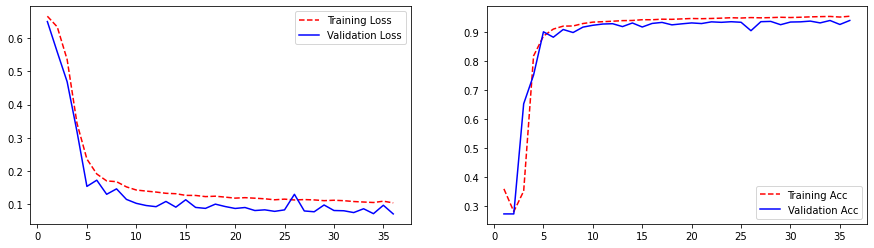

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss)+1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Acc', 'Validation Acc'])

## 5. Validation
<div id='validation'></div>

In [ ]:
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)
        img = np.where(img > 127, 255, 0)
        
        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv.imwrite(result_file, img)

In [17]:
checkpoint_path = './model/lung_seg.h5'
model = load_model(checkpoint_path)

test_gen = test_generator(val_image_data, target_size=(256, 256))
results = model.predict(test_gen, verbose=1)
save_result(SAVE_RESULT, results, val_image_data)

278/278 [==============================] - 25s 90ms/step


## 6. Show Results
<div id='results'></div>

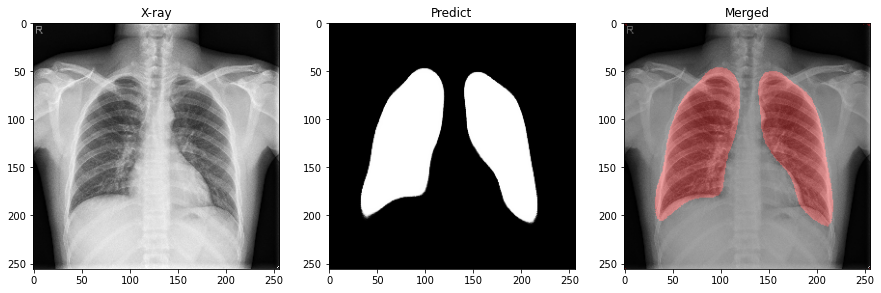

In [18]:
im = cv.imread(os.path.join(TEST_DIR_IMAGE, test_images[131]))
im1 = cv.imread(os.path.join(SAVE_RESULT, os.path.splitext(test_images[131])[0] + '_predict.png'))
merged_im = add_colored_mask(im, im1)
fig, axs = plt.subplots(1,3, figsize=(15,8))
axs[0].set_title('X-ray')
axs[0].imshow(im)

axs[1].set_title('Predict')
axs[1].imshow(im1)

axs[2].set_title('Merged')
axs[2].imshow(merged_im)

# 7. Crop image and save before classification or detection

In [ ]:
ORIGINAL_PATH = "./data/image_for_crop/original/"
PREDICT_PATH = "./result/"
SAVE_PATH = "./data/image_for_crop/cropped/"

In [ ]:
from uitilities.crop_image import cropped_image
cropped_image(ORIGINAL_PATH=ORIGINAL_PATH, PREDICT_PATH=PREDICT_PATH, SAVE_PATH=SAVE_PATH)